# Process Baysis traffic count data
Source: https://www.baysis.bayern.de/web/content/verkehrsdaten/dauerzaehlstellen.aspx

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os.path import isfile, join

In [2]:
#path to downloaded data
path = '../data/mobility/raw_data/ZaehlstellenBaysis/raw/'

## Change file name of Baysis data

In [3]:
files = [f for f in os.listdir(path) if f.endswith(".xlsx") and
                  isfile(join(path, f)) and not f.startswith('.')]

#loop over files and replace word for month by number of month
for f in files:
    try:
        if 'januar' in f:
            month_name = 'januar'
            month = '01'
        elif 'februar' in f:
            month_name = 'februar'
            month = '02'
        elif 'maerz' in f:
            month_name = 'maerz'
            month = '03'
        elif 'april' in f:
            month_name = 'april'
            month = '04'
        elif 'mai' in f:
            month_name = 'mai'
            month = '05'
        elif 'juni' in f:
            month_name = 'juni'
            month = '06'
        elif 'juli' in f:
            month_name = 'juli'
            month = '07'
        elif 'august' in f:
            month_name = 'august'
            month = '08'
        elif 'september' in f:
            month_name = 'september'
            month = '09'
        elif 'oktober' in f:
            month_name = 'oktober'
            month = '10'
        elif 'november' in f:
            month_name = 'november'
            month = '11'
        elif 'dezember' in f:
            month_name = 'dezember'
            month = '12'

        os.rename(path + f, path + f.replace(month_name,month))
    except:
        print(f + ' ' + 'already processed!')


monatsauswertung_02_2018.xlsx already processed!
monatsauswertung_09_2019.xlsx already processed!
monatsauswertung_07_2017.xlsx already processed!
monatsauswertung_01_2020.xlsx already processed!
monatsauswertung_10_2019.xlsx already processed!
monatsauswertung_04_2019.xlsx already processed!
monatsauswertung_04_2018.xlsx already processed!
monatsauswertung_01_2017.xlsx already processed!
monatsauswertung_10_2018.xlsx already processed!
monatsauswertung_09_2018.xlsx already processed!
monatsauswertung_02_2019.xlsx already processed!
monatsauswertung_08_2019.xlsx already processed!
monatsauswertung_06_2017.xlsx already processed!
monatsauswertung_03_2018.xlsx already processed!
monatsauswertung_12_2017.xlsx already processed!
monatsauswertung_05_2019.xlsx already processed!
monatsauswertung_11_2019.xlsx already processed!
monatsauswertung_11_2018.xlsx already processed!
monatsauswertung_05_2018.xlsx already processed!
monatsauswertung_03_2019.xlsx already processed!
monatsauswertung_08_

## Read Baysis data and create Pandas dataframe

In [4]:
files = [f for f in os.listdir(path) if f.endswith(".xlsx") and
                  isfile(join(path, f)) and not f.startswith('.')]

df_all = pd.DataFrame()

#loop over all available files
for f in files:
    try:
        #read file and drop some rows
        df = pd.read_excel(path + f, 'Tab_ZIS', skiprows=1)
        df = df.drop([0,1,2], axis=0)
    
        #get year and month information
        year_month = f[-9:-5] + '-' + f[-12:-10]

        #reduce to important columns and dropna
        df = df[['Zstnr', 'Kfz', 'Str.']]
        df = df.dropna()
        df.Zstnr = df.Zstnr.str.replace('*', '')

        #possibility to drop K and S street types because BAST data is only available for B and A street types
        #it is not done because in the feature value it is basically just a bias offset and with K and S datatype it matches more the Germany wide data
        """
        row, col = df.shape
        df = df.reset_index(drop=True)
        for i in range(0,row):
            if 'K' in df['Str.'][i] or 'S' in df['Str.'][i]:
                df = df.drop(i,axis=0)
        df = df.drop('Str.', axis=1)
        """
        df = df.reset_index(drop=True)
        row, col = df.shape

        #transpose dataframe
        nr = np.array(df.Zstnr, 'str')
        kfz = np.array(df['Kfz'])

        df = pd.DataFrame()
        for i in range(0,len(nr)):
            df[nr[i]] = [kfz[i]]

        #save date information in dataframe
        df['date'] = year_month

        #append it to general dataframe
        df_all = df_all.append(df)
    except:
        print(year_month, ': ', df.Zstnr)

#date as index
df_all.date = pd.to_datetime(df_all.date).dt.to_period('m')    
df_all.index = df_all.date
df_all = df_all.sort_index(axis=0)

2017-01 :  Series([], Name: Zstnr, dtype: float64)


## Baysis data values are DTV (durchschnittliche tägliche Verkehrsstärke) which means average number of vehicles per day in the corresponding month -> need to change it to total numbers of vehicles per month

Weight DTV with number of days in each month. This is not negligible because we have to weight e.g. January with 31 days stronger than Febraury with 28/29 days.

In [6]:
#arrays with number of days of each month (data is only available for Feb 2017 until March 2020)
days_arr_2017 = np.array([28,31,30,31,30,31,31,30,31,30,31])
days_arr_2018 = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
days_arr_2019 = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
days_arr_2020 = np.array([31,29,31,30])
days_arr = np.append(days_arr_2017, days_arr_2018)
days_arr = np.append(days_arr, days_arr_2019)
days_arr = np.append(days_arr, days_arr_2020)

#weight each column with number of days
for column in df_all:
    if column != 'date':
        df_all[column] = df_all[column].values * days_arr


In [7]:
#save csv with monthly data and each station separately
df_all.to_csv('../data/mobility/raw_data/ZaehlstellenBaysis/Baysis_CountingStations_monthly.csv')

## Create csv with feature data
Because we do not want to have each counting station as a feature and also not all counting stations are available for the whole time the values of the counting stations are averaged to one feature.

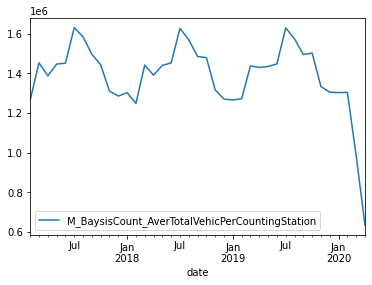

In [8]:
#create feature that has the average number of vehicles in the corresponding month per station
df_feature = df_all
df_feature['M_BaysisCount_AverTotalVehicPerCountingStation'] = df_feature.mean(axis=1, skipna=True)
df_feature = df_feature[['M_BaysisCount_AverTotalVehicPerCountingStation']]

#save feature csv
df_feature.to_csv('../data/mobility/Baysis_CountingStations_Feature_monthly.csv')

#Plot the feature
df_feature.plot()